In [1]:
import os
import cv2
import PIL
import glob
import wandb
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sn
import typing as tp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms

from dataclasses import dataclass
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader

wandb.require("core")

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [2]:
# Fixind all seeds in order to get the same results every time
def fix_seeds(seed, reproducible=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if reproducible:
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.benchmark = False
    else:
        torch.use_deterministic_algorithms(False)
        torch.backends.cudnn.benchmark = True

    
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
# GPU or CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Device: ', device)

Device:  cuda


In [4]:
# Cancels normalization of images to print them 
def myshow(img):
    img = img * 0.3 + 0.3
    npimg = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0))

In [5]:
# Train/Validation/Test split
df = pd.read_csv('data/sports.csv')

train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

train_df.shape[0], valid_df.shape[0], test_df.shape[0]

(13492, 500, 500)

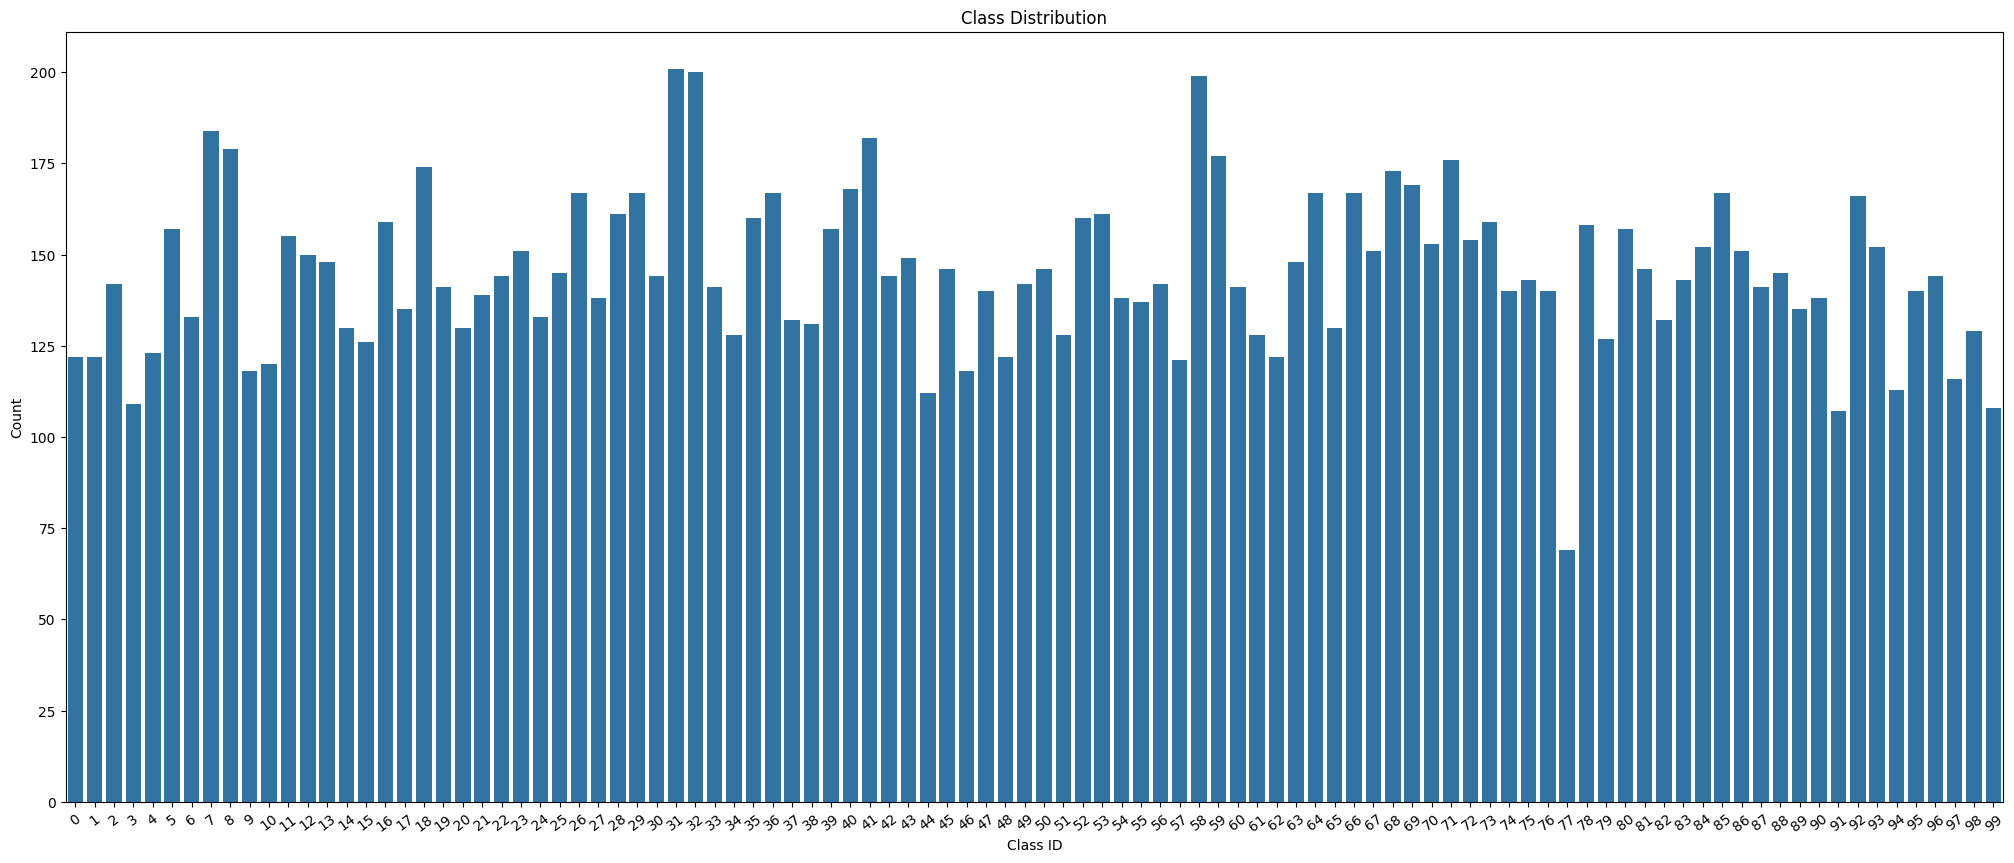

In [41]:
class_counts = df['class id'].value_counts().sort_index()

plt.figure(figsize=(25, 10))
sn.barplot(x=class_counts.index, y=class_counts.values)

plt.xlabel("Class ID")
plt.ylabel("Count")
plt.xticks(rotation=37)
plt.title("Class Distribution")
plt.show()

In [6]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform=transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join('data', row['filepaths'])
        label = torch.tensor(row['class id'], dtype=torch.long)

        if os.path.exists(image_path): # checks if a file exists
            try:
                image = PIL.Image.open(image_path).convert('RGB') # if the file has wrong extension, it won't open
            except Exception as e:
                raise TypeError(f'Could not open the file at {image_path}: {e}')
        else:
            raise FileNotFoundError(f'File at {image_path} does not exist')

        if self.transform: # applying transformations if they were given
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.df)

In [7]:
# This function initiates 1 of 3 schedulers
def get_scheduler(config, optimizer, step=None, gamma=None):
    if config.scheduler_type == 'exp':
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif config.scheduler_type == 'step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
    elif config.scheduler_type == 'cosine':
        T_max = config.epochs * len(train_loader) 
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
    else:
        return None

In [14]:
def run_epoch(model, loader, loss_fn, optimizer, epoch, device, scheduler, state, config):
    assert state in ['train', 'validation', 'test'], 'Wrong model state' # checks if the state was given correctly
    
    if state == 'train':
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    all_predictions = []
    all_labels = []
    lr = config.lr

    for i, batch in tqdm(enumerate(loader), total=len(loader), desc=f'{state.capitalize()} Epoch {epoch+1}'): # progress bar
        image, label = batch
        image, label = image.to(device), label.to(device) # putting the data into device
        
        output = model(image) # logits
        loss = loss_fn(output, label)

        if state == 'train':
            optimizer.zero_grad() # deleting previous gradient if there were
            loss.backward() # calculating gradients
            optimizer.step()

            if (scheduler is not None) and (config.scheduler_type == 'cosine'): # cosine scheduler requiers stepping every batch
                scheduler.step()
                lr = scheduler.get_last_lr()[0]

        epoch_loss += loss.item() 
        _, predictions = torch.max(output.data, 1) # # take index of max logit per sample
        
        all_predictions.append(predictions.cpu().numpy()) # saving all model prediction on this batch
        all_labels.append(label.cpu().numpy())

    all_predictions = np.concatenate(all_predictions) # model predictions [[1,2,3], [3,4,5] --> [1,2,3,3,4,5]
    all_labels = np.concatenate(all_labels)

    epoch_loss = epoch_loss / (i + 1) # average loss for this batch
    accuracy = (all_predictions == all_labels).sum() / len(all_labels) 
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)

    print(f'Loss: {epoch_loss:.3f}, Accuracy: {accuracy:.3f}, Balanced Accuracy: {balanced_accuracy:.3f}')

    if state == 'train':
        if (scheduler is not None) and (config.scheduler_type != 'cosine'):
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
            
        wandb.log({'LR': lr}, step=epoch + 1)
        
    log_prefix = state.capitalize() # wandb logs to get plots
    wandb.log({ 
        f"{log_prefix} Loss": epoch_loss,
        f"{log_prefix} Accuracy": accuracy * 100,
        f"{log_prefix} Balanced Accuracy": balanced_accuracy * 100
    }, step=epoch + 1)

    return epoch_loss, accuracy, balanced_accuracy, all_predictions, all_labels

In [9]:
@dataclass
class Config:
    seed:int = 42
    img_size: int = 224
    batch_size: int = 32
    lr: float = 1e-4
    epochs: int = 10
    scheduler_type: tp.Literal['exp', 'step', 'cosine'] | None = 'cosine'

config = Config()
fix_seeds(config.seed, True)

generator = torch.Generator()
generator.manual_seed(config.seed)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.TrivialAugmentWide(),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3]), # imagenet normalization
    transforms.RandomErasing()
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

train_dataset = CustomDataset(train_df, train_transform)
valid_dataset = CustomDataset(valid_df, test_transform)
test_dataset = CustomDataset(test_df, test_transform)

train_loader = DataLoader(
    train_dataset,
    config.batch_size,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator
)

valid_loader = DataLoader(
    valid_dataset,
    config.batch_size,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    config.batch_size,
    num_workers=12,
    pin_memory=True,
)

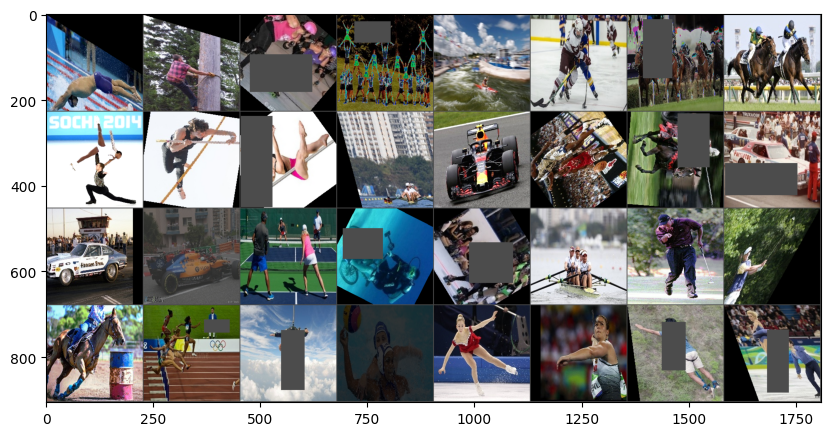

In [45]:
images, labels = next(iter(trainloader))
myshow(torchvision.utils.make_grid(images))

In [11]:
model = models.resnet50(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 100)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config.lr)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(config, optimizer)

In [12]:
wandb.init(
    project='Sports Image Classification',
    name='12. Adam + larger images',
    config=config.__dict__
) 

best_score = float('inf')
patience = 3
wait = 0

for epoch in range(config.epochs):
    print(f'Training {epoch+1}/{config.epochs}')
    _, _, _, _, _ = run_epoch(model, train_loader, loss_fn, optimizer, epoch, device, scheduler, 'train', config) # train model

    print('Validation')
    with torch.no_grad():
        epoch_loss, _, _, _, _ = run_epoch(model, valid_loader, loss_fn, optimizer, epoch, device, scheduler, 'validation', config) # validate model
    print('------------------------')

    if epoch_loss >= best_score: # early stopping
        wait += 1
        print(f'No improvement! Patience {wait}/{patience}')
    else:
        wait = 0
        best_score = epoch_loss
        torch.save(model.state_dict(), "model/model.pt")
        torch.save(optimizer.state_dict(), "model/optimizer.pt")
        
    if wait == patience:
        print(f'Stopping the learning')
        break

model.load_state_dict(torch.load("model/model.pt", weights_only=True))
model.eval()

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: karibay (karibay-google). Use `wandb login --relogin` to force relogin


Training 1/10


Train Epoch 1: 100%|██████████████████████████████████████████████████████████████████| 421/421 [03:05<00:00,  2.27it/s]

Loss: 1.939, Accuracy: 0.586, Balanced Accuracy: 0.577
Validation




alidation Epoch 1: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.60it/s]

Loss: 0.272, Accuracy: 0.936, Balanced Accuracy: 0.936
------------------------
Training 2/10


Train Epoch 2: 100%|██████████████████████████████████████████████████████████████████| 421/421 [03:09<00:00,  2.22it/s]

Loss: 0.479, Accuracy: 0.882, Balanced Accuracy: 0.880
Validation




alidation Epoch 2: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]

Loss: 0.139, Accuracy: 0.962, Balanced Accuracy: 0.962
------------------------
Training 3/10


Train Epoch 3: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:58<00:00,  2.37it/s]

Loss: 0.299, Accuracy: 0.924, Balanced Accuracy: 0.923
Validation




alidation Epoch 3: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]

Loss: 0.095, Accuracy: 0.974, Balanced Accuracy: 0.974
------------------------
Training 4/10


Train Epoch 4: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:56<00:00,  2.39it/s]

Loss: 0.216, Accuracy: 0.945, Balanced Accuracy: 0.944
Validation




alidation Epoch 4: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.37it/s]

Loss: 0.078, Accuracy: 0.980, Balanced Accuracy: 0.980
------------------------
Training 5/10


Train Epoch 5: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:55<00:00,  2.40it/s]

Loss: 0.162, Accuracy: 0.960, Balanced Accuracy: 0.960
Validation




alidation Epoch 5: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.99it/s]

Loss: 0.065, Accuracy: 0.984, Balanced Accuracy: 0.984
------------------------
Training 6/10


Train Epoch 6: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:55<00:00,  2.40it/s]

Loss: 0.133, Accuracy: 0.968, Balanced Accuracy: 0.967
Validation




alidation Epoch 6: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]

Loss: 0.058, Accuracy: 0.984, Balanced Accuracy: 0.984
------------------------
Training 7/10


Train Epoch 7: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:53<00:00,  2.43it/s]

Loss: 0.109, Accuracy: 0.972, Balanced Accuracy: 0.972
Validation




alidation Epoch 7: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.59it/s]

Loss: 0.058, Accuracy: 0.980, Balanced Accuracy: 0.980
------------------------
Training 8/10


Train Epoch 8: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:58<00:00,  2.35it/s]

Loss: 0.102, Accuracy: 0.974, Balanced Accuracy: 0.973
Validation




alidation Epoch 8: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.43it/s]

Loss: 0.053, Accuracy: 0.990, Balanced Accuracy: 0.990
------------------------
Training 9/10


Train Epoch 9: 100%|██████████████████████████████████████████████████████████████████| 421/421 [02:57<00:00,  2.37it/s]

Loss: 0.089, Accuracy: 0.978, Balanced Accuracy: 0.978
Validation




alidation Epoch 9: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s]

Loss: 0.050, Accuracy: 0.988, Balanced Accuracy: 0.988
------------------------
Training 10/10


Train Epoch 10: 100%|█████████████████████████████████████████████████████████████████| 421/421 [02:54<00:00,  2.41it/s]

Loss: 0.087, Accuracy: 0.979, Balanced Accuracy: 0.979
Validation




alidation Epoch 10: 100%|██████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.80it/s]

Loss: 0.049, Accuracy: 0.988, Balanced Accuracy: 0.988
------------------------


/tmp/ipykernel_35376/405990866.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))


LR,█▇▇▆▅▃▂▂▁▁
Train Accuracy,▁▆▇▇██████
Train Balanced Accuracy,▁▆▇▇██████
Train Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇▇███
Validation Balanced Accuracy,▁▄▆▇▇▇▇███
Validation Loss,█▄▂▂▂▁▁▁▁▁
LR,0
Train Accuracy,97.89935
Train Balanced Accuracy,97.88913
Train Loss,0.08707


In [15]:
wandb.init(
    project='Sports Image Classification',
    name='12V - Test',
    config=config.__dict__
) 

print('Validation')
with torch.no_grad():
    _, _, _, all_predictions, all_labels= run_epoch(model, test_loader, loss_fn, optimizer, epoch, device, scheduler, 'test', config) # test model
print('------------------------')

wandb.finish()

Validation



est Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.10it/s]

Loss: 0.036, Accuracy: 0.990, Balanced Accuracy: 0.990
------------------------


Test Accuracy,▁
Test Balanced Accuracy,▁
Test Loss,▁
Test Accuracy,99
Test Balanced Accuracy,99
Test Loss,0.03614


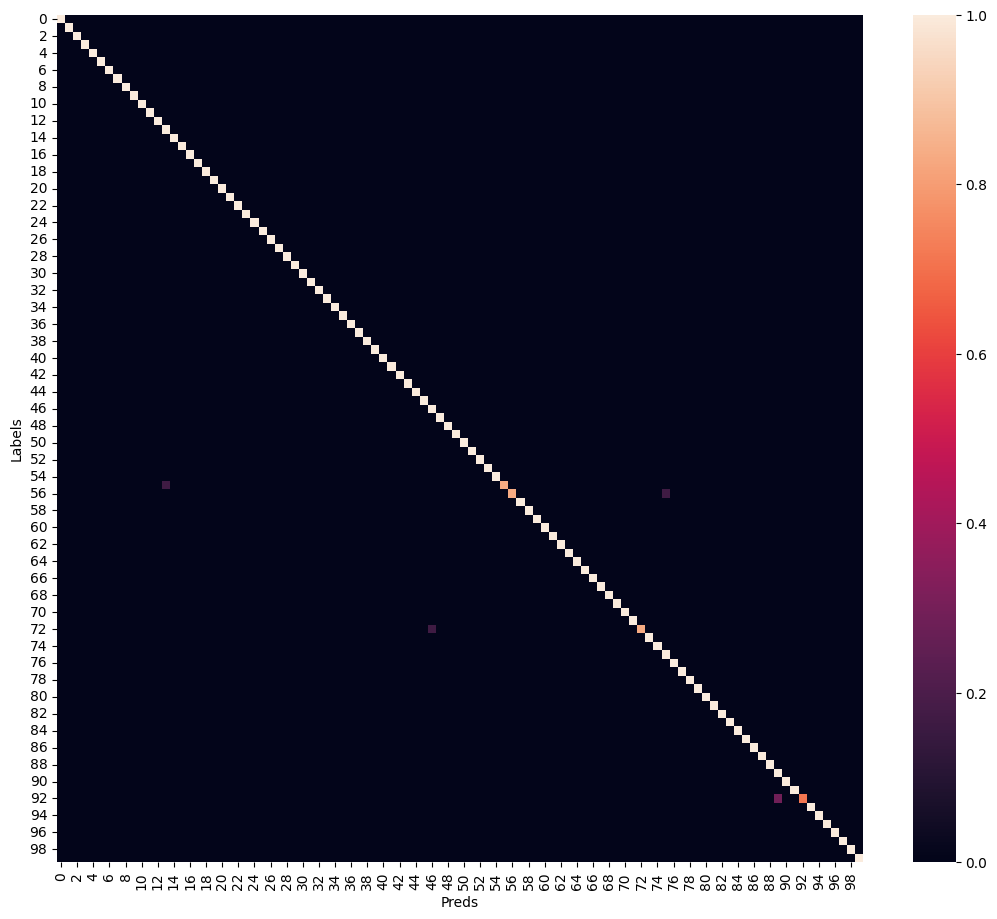

In [17]:
cm = confusion_matrix(all_predictions, all_labels, normalize='true')
                                
plt.figure(figsize = (13, 11))
ax = sn.heatmap(cm)
ax.set(xlabel='Preds', ylabel='Labels')
plt.show()